## Mechanical Turk Depth Duration (Batch 1-4) Analysis

In [477]:
import os 
import pandas as pd
import numpy as np
import math

def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                # ONLY for test data NOT for actual 
        #         noNan_df = df[:10] 
        #         data.append(noNan_df)
                # uncomment line below for ACTUAL data 
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
            input_data.at[idx, 'unitSelection'] = 'meters'

        
    
    return input_data

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = getUnitConveredData(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)
    
    return input_data



def durationDfs(datafolder):
    """
    Seperate the the data into seperate dataframes for each duration condition
    """
    
    cleaned_data = removeMissedTrials(datafolder)
    
    data_250ms = cleaned_data[cleaned_data['duration'] == 250.0]
    data_500ms = cleaned_data[cleaned_data['duration'] == 500.0]
    data_750ms = cleaned_data[cleaned_data['duration'] == 750.0]
    data_1000ms = cleaned_data[cleaned_data['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]

def roundActualDepth(datafolder):
    """
    Round Actual Depth value to nearest tenth
    - Actual depth values from the Kinect are very specific (ex. 3.128)
    - Need to round to calculate meaningful outlier params 
    """
    data = durationDfs(datafolder)
    
    for duration in data:
        for idx, row in duration.iterrows():
            actual_depth = row['actual_depth']
            rounded_depth = round(actual_depth,1) # round depth to the nearest tenth
            duration.at[idx,'actual_depth'] = rounded_depth      
        
    return data

# def removeIncorrectlyTaggedImageTrials(datafolder):
#     """
#     Kinect depth tagging is incorrect 
#     Not caught by previous effort to remove targets that are on the floor or wall 
#     because the target is on a chair that is flush with the wall.
    
#     """
    
#     data = roundActualDepth(datafolder)
#     remove_images = ['depth_duration_stimuli/001559_6/001559_6-target.png'
#                      ,'depth_duration_stimuli/003532_7/003532_7-target.png']
#     for df in data:
#         for index, row in df.iterrows():
#             if row['stimulus'] in remove_images:
#                 df.drop(index, inplace=True)
    
#     return data 

def outlierRemoval(datafolder): 
    # TEST NO OUTLIER REMOVAL 
    """
    For each duration, the average depth estimation for a certain actual depth is calculated 
    Calculates outlier range: (-3SD, +3SD) --> if an estimate is outside the range for that depth then remove as outlier 
    """
    
    data = roundActualDepth(datafolder)
#     return data 
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        
        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    ###### ADD OUTLIER PARAMS TO DF ######
    all_dict_outlier_params = [] #list of dictionaries with outlier params for each depth 
    for table in result_tables:
        dur_dict_outlier_params = {}
        #lists of outlier parameters for each depth bin 
        lst_minus3SD = []
        lst_plus3SD = []
        for idx, row in table.iterrows():
            avg = row["Average Estimated Depth"]
            std = row["Standard Deviation"]
            
            #calculate outlier parameters 
            avg_minus_3SD =  avg - ( 3 * std)
            avg_minus_3SD = round(avg_minus_3SD, 3)
            lst_minus3SD.append(avg_minus_3SD)
            
            avg_plus_3SD = avg + ( 3 * std)
            avg_plus_3SD = round(avg_plus_3SD, 3)
            lst_plus3SD.append(avg_plus_3SD)
            
            dur_dict_outlier_params[idx] = [avg_minus_3SD, avg_plus_3SD]
        
        #add outlier parameters for each depth bin to the data frame 
        table["Avg-3SD"] = lst_minus3SD
        table["Avg+3SD"] = lst_plus3SD
        all_dict_outlier_params.append(dur_dict_outlier_params)
            
    ###### LABEL EACH ESTIMATE AS OUTLIER OR NOT (0, 1) IN OG DATA DF ######
    condition = 0
    for duration in data:
        outlier = [] #list of outlier status for each estimation
        for idx, row in duration.iterrows():
            actual_depth = row["actual_depth"]
            
            outlier_params = all_dict_outlier_params[condition][actual_depth]
            minus_3SD = outlier_params[0]
            plus_3SD = outlier_params[1]
            
            estimated_depth = row["depth_estimate"]
            
            # If there is only one observation for a certain depth, the std will be NaN 
            # This can be the case when conducting the analysis on a participant by participant basis 
            # In this case, the outlier params are invalid, so set outlier status to 0
            if math.isnan(minus_3SD) == True:
                outlier.append(0)
                continue 
            if math.isnan(plus_3SD) == True:
                outlier.append(0)
                continue
            if estimated_depth < minus_3SD:
                outlier.append(1)
                continue
            if estimated_depth > plus_3SD:
                outlier.append(1)
                continue
            else:
                outlier.append(0)
        

        duration["Outlier"] = outlier
        condition += 1
        
    ###### COUNT NUMBER OF OUTLIERS AND REMOVE OUTLIERS ######
    pre_outlier = data
    post_outlier = data
    
    outliers_participants = {}
    outliers_durations = {}
    outliers_sequences = {}
    for dur in pre_outlier:
        for idx, row in dur.iterrows():
            outlier = row["Outlier"]
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']            
            if outlier == 1:
                if subjID not in outliers_participants:
                    outliers_participants[subjID] = 1
                else:
                    outliers_participants[subjID] += 1

                if duration not in outliers_durations:
                    outliers_durations[duration] = 1
                else:
                    outliers_durations[duration] += 1

                if sequenceName not in outliers_sequences:
                    outliers_sequences[sequenceName] = 1
                else:
                    outliers_sequences[sequenceName] += 1
    
#     # Check if a particular participant, duration, or sequence has lots of outliers 
#     print("Outliers")
#     print(outliers_participants)
#     print(outliers_durations)
#     print(outliers_sequences)
    
    subjID_outlier = {}
    for dur in post_outlier: #if the value is an outlier, then remove it 
        indexNames = dur[dur["Outlier"] == 1].index
        dur.drop(indexNames, inplace=True)

            
    return post_outlier

def pivotTable(datafolder):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    data = outlierRemoval(datafolder)
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        
        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
    
    return result_tables
    

In [463]:
# p = '/Users/prachi/Documents/depth_duration/analysis/data'
# x = removeIncorrectlyTaggedImageTrials(p)[3]


#### INCORRECT DEPTH TAGGING 
/Users/prachi/Documents/depth_duration/mturk_code/depth_duration_MTurk/depth_duration_stimuli/001559_6

/Users/prachi/Documents/depth_duration/mturk_code/depth_duration_MTurk/depth_duration_stimuli/003532_7

Not caught by previous effort to remove targets that are on the floor or wall because the target is on a chair that is flush with the wall.

Need to remove these trials. 


In [464]:
# sorted_df = x.sort_values(by=['actual_depth'], ascending=True)
# sorted_df

In [478]:
import scipy.stats as stats

def getxy(datafolder):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        xs = [x_250, x_500, x_750, x_1000]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    data = pivotTable(datafolder)
    xs = []
    ys = []
    stes = []
    for table in data:
        x = []
        y = []
        ste = []
        for idx, row in table.iterrows():
            x.append(idx) #idx is the actual depth value 
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        
    return xs, ys, stes 

def createVars(folderpath):
    """
    Create variables for final data by duration, for a specific sequence 
    """
    final_data = getxy(folderpath)
    final_x_250 = final_data[0][0]
    final_y_250 = final_data[1][0]
    ste_250 = final_data[2][0]

    final_x_500 = final_data[0][1]
    final_y_500 = final_data[1][1]
    ste_500 = final_data[2][1]

    final_x_750 = final_data[0][2]
    final_y_750 = final_data[1][2]
    ste_750 = final_data[2][2]

    final_x_1000 = final_data[0][3]
    final_y_1000 = final_data[1][3]
    ste_1000 = final_data[2][3]
    
    return [[final_x_250, final_y_250, ste_250], 
            [final_x_500, final_y_500, ste_500], 
            [final_x_750, final_y_750, ste_750], 
            [final_x_1000, final_y_1000, ste_1000]]

#Calculate the T-test for the means of two independent samples of scores.

#This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 
#This test assumes that the populations have identical variances by default.
def durationStatsTests(folderpath):
    finaldata = createVars(folderpath)
    
    final_y_250 = finaldata[0][1]
    final_y_500 = finaldata[1][1]
    final_y_750 = finaldata[2][1]
    final_y_1000 = finaldata[3][1]
    
    print("250ms vs. 500ms")
    ttest_250_500 = stats.ttest_ind(final_y_250,final_y_500)
    print(ttest_250_500)
    print("250ms vs. 750ms")
    ttest_250_750 = stats.ttest_ind(final_y_250,final_y_750)
    print(ttest_250_750)
    print("250ms vs. 1000ms")
    ttest_250_1000 = stats.ttest_ind(final_y_250,final_y_1000)
    print(ttest_250_1000)
    print("500ms vs. 750ms")
    ttest_500_750 = stats.ttest_ind(final_y_500,final_y_750)
    print(ttest_500_750)
    print("500ms vs. 1000ms")
    ttest_500_1000 = stats.ttest_ind(final_y_500,final_y_1000)
    print(ttest_500_1000)
    print("750ms vs. 1000ms")
    ttest_750_1000 = stats.ttest_ind(final_y_750,final_y_1000)
    print(ttest_750_1000)
    
    # stats f_oneway functions takes the groups as input and returns F and P-value
    fvalue, pvalue = stats.f_oneway(final_y_250, final_y_500, final_y_750, final_y_1000)
    print("All durations: fvalue=", fvalue, "pvalue=",pvalue)
    
    return None 


data_path = '/Users/prachi/Documents/depth_duration/analysis/data'
normalized_path = '/Users/prachi/Documents/depth_duration/analysis/normalized_data'
participOutlierCleaning_normalized = '/Users/prachi/Documents/depth_duration/analysis/cleaned_normalized_data'
avgEstim_cleaned = '/Users/prachi/Documents/depth_duration/analysis/data_avgEstim_cleaned'

durationStatsTests(avgEstim_cleaned)

250ms vs. 500ms
Ttest_indResult(statistic=-1.3138683599759475, pvalue=0.19264573585519945)
250ms vs. 750ms
Ttest_indResult(statistic=-0.7753947139573439, pvalue=0.44042139516435697)
250ms vs. 1000ms
Ttest_indResult(statistic=-1.3118666586089536, pvalue=0.19331724027566782)
500ms vs. 750ms
Ttest_indResult(statistic=0.44725083383311126, pvalue=0.6559178405145243)
500ms vs. 1000ms
Ttest_indResult(statistic=-0.10619138001322906, pvalue=0.9156963411185621)
750ms vs. 1000ms
Ttest_indResult(statistic=-0.5192068298272903, pvalue=0.6050680909845565)
All durations: fvalue= 0.6745096536530082 pvalue= 0.5688732288760224


<AxesSubplot:>

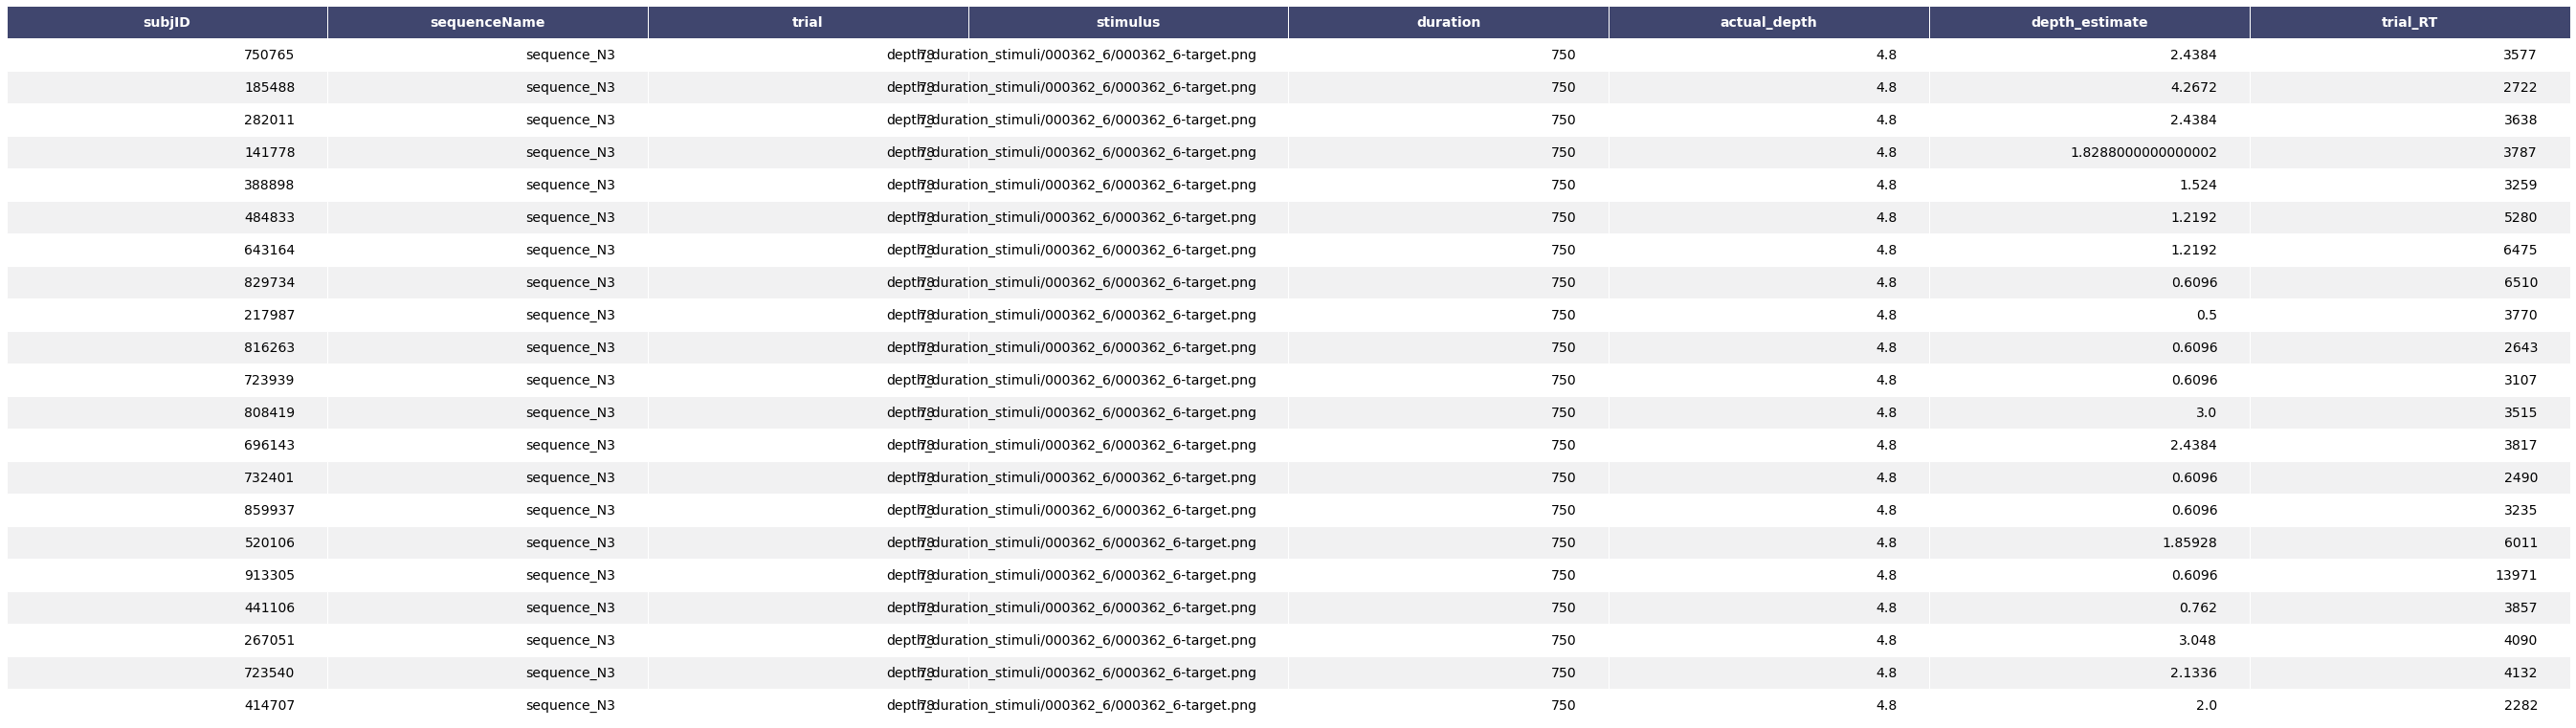

In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six

data_path = '/Users/prachi/Documents/depth_duration/analysis/data'
avgEstim_cleaned = '/Users/prachi/Documents/depth_duration/analysis/data_avgEstim_cleaned'


rawdata = outlierRemoval(avgEstim_cleaned)


raw_duration = rawdata[2]

raw_duration_at_depth = raw_duration.loc[raw_duration['actual_depth'] == 4.8]


def render_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    data = data.drop(['experimentName', 'versionName', 'url', 'selected_row', 'windowWidth', 'windowHeight', 'screenWidth', 'screenHeight', 'startDate', 'startTime', 'log_sceneDuration', 'Outlier', 'experimentTime', 'totalTime', 'unitSelection'], axis=1)
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_table(raw_duration_at_depth, header_columns=0, col_width=6.0)

### INCORRECT DEPTH TAGGING 
/Users/prachi/Documents/depth_duration/mturk_code/depth_duration_MTurk/depth_duration_stimuli/001559_6

/Users/prachi/Documents/depth_duration/mturk_code/depth_duration_MTurk/depth_duration_stimuli/003532_7

Not caught by previous effort to remove targets that are on the floor or wall because the target is one a chair that is flush with the wall. 



In [449]:

remove = ['001559_6', '003532_7']

In [83]:
N1_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N1"
N2_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N2"
N3_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N3"
N4_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N4"

df_N1 = pivotTable(N1_path)
df_N2 = pivotTable(N2_path)
df_N3 = pivotTable(N3_path)
df_N4 = pivotTable(N4_path)

import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue250, pvalue250 = stats.f_oneway(df_N1[0]['Average Estimated Depth'],
                                df_N2[0]['Average Estimated Depth'],
                                df_N3[0]['Average Estimated Depth'],
                                df_N4[0]['Average Estimated Depth'])
print("250 - All Sequences:", fvalue250, pvalue250)

fvalue500, pvalue500 = stats.f_oneway(df_N1[1]['Average Estimated Depth'],
                                df_N2[1]['Average Estimated Depth'],
                                df_N3[1]['Average Estimated Depth'],
                                df_N4[1]['Average Estimated Depth'])
print("500 - All Sequences:", fvalue500, pvalue500)

fvalue750, pvalue750 = stats.f_oneway(df_N1[2]['Average Estimated Depth'],
                                df_N2[2]['Average Estimated Depth'],
                                df_N3[2]['Average Estimated Depth'],
                                df_N4[2]['Average Estimated Depth'])
print("750 - All Sequences:", fvalue750, pvalue750)

fvalue1000, pvalue1000 = stats.f_oneway(df_N1[3]['Average Estimated Depth'],
                                df_N2[3]['Average Estimated Depth'],
                                df_N3[3]['Average Estimated Depth'],
                                df_N4[3]['Average Estimated Depth'])
print("1000 - All Sequences:", fvalue1000, pvalue1000)


250 - All Sequences: 85.82564348484439 1.3701611467371509e-30
500 - All Sequences: 69.30626271341059 1.0924255083510492e-26
750 - All Sequences: 53.33185620701641 1.5338802874701237e-22
1000 - All Sequences: 53.140794232967025 7.230371255440185e-22


In [84]:
N1_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N1"
N2_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N2"
N3_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N3"
N4_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N4"

df_N1 = pivotTable(N1_path)
df_N2 = pivotTable(N2_path)
df_N3 = pivotTable(N3_path)
df_N4 = pivotTable(N4_path)

import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue250, pvalue250 = stats.f_oneway(df_N1[0]['Average Estimated Depth'],
                                df_N2[0]['Average Estimated Depth'])
print("250 - N1 N2:", fvalue250, pvalue250)

fvalue500, pvalue500 = stats.f_oneway(df_N1[1]['Average Estimated Depth'],
                                df_N2[1]['Average Estimated Depth'])
print("500 - N1 N2:", fvalue500, pvalue500)

fvalue750, pvalue750 = stats.f_oneway(df_N1[2]['Average Estimated Depth'],
                                df_N2[2]['Average Estimated Depth'])
print("750 - N1 N2:", fvalue750, pvalue750)

fvalue1000, pvalue1000 = stats.f_oneway(df_N1[3]['Average Estimated Depth'],
                                df_N2[3]['Average Estimated Depth'])
print("1000 - N1 N2:", fvalue1000, pvalue1000)
print("\n")

#####################################################################################

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue250, pvalue250 = stats.f_oneway(df_N1[0]['Average Estimated Depth'],
                                df_N3[0]['Average Estimated Depth'])
print("250 - N1 N3:", fvalue250, pvalue250)

fvalue500, pvalue500 = stats.f_oneway(df_N1[1]['Average Estimated Depth'],
                                df_N3[1]['Average Estimated Depth'])
print("500 - N1 N3:", fvalue500, pvalue500)

fvalue750, pvalue750 = stats.f_oneway(df_N1[2]['Average Estimated Depth'],
                                df_N3[2]['Average Estimated Depth'])
print("750 - N1 N3:", fvalue750, pvalue750)

fvalue1000, pvalue1000 = stats.f_oneway(df_N1[3]['Average Estimated Depth'],
                                df_N3[3]['Average Estimated Depth'])
print("1000 - N1 N3:", fvalue1000, pvalue1000)
print("\n")

#####################################################################################

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue250, pvalue250 = stats.f_oneway(df_N1[0]['Average Estimated Depth'],
                                df_N4[0]['Average Estimated Depth'])
print("250 - N1 N4:", fvalue250, pvalue250)

fvalue500, pvalue500 = stats.f_oneway(df_N1[1]['Average Estimated Depth'],
                                df_N4[1]['Average Estimated Depth'])
print("500 - N1 N4:", fvalue500, pvalue500)

fvalue750, pvalue750 = stats.f_oneway(df_N1[2]['Average Estimated Depth'],
                                df_N4[2]['Average Estimated Depth'])
print("750 - N1 N4:", fvalue750, pvalue750)

fvalue1000, pvalue1000 = stats.f_oneway(df_N1[3]['Average Estimated Depth'],
                                df_N4[3]['Average Estimated Depth'])
print("1000 - N1 N4:", fvalue1000, pvalue1000)
print("\n")

#####################################################################################

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue250, pvalue250 = stats.f_oneway(df_N2[0]['Average Estimated Depth'],
                                df_N3[0]['Average Estimated Depth'])
print("250 - N2 N3:", fvalue250, pvalue250)

fvalue500, pvalue500 = stats.f_oneway(df_N2[1]['Average Estimated Depth'],
                                df_N3[1]['Average Estimated Depth'])
print("500 - N2 N3:", fvalue500, pvalue500)

fvalue750, pvalue750 = stats.f_oneway(df_N2[2]['Average Estimated Depth'],
                                df_N3[2]['Average Estimated Depth'])
print("750 - N2 N3:", fvalue750, pvalue750)

fvalue1000, pvalue1000 = stats.f_oneway(df_N2[3]['Average Estimated Depth'],
                                df_N3[3]['Average Estimated Depth'])
print("1000 - N2 N3:", fvalue1000, pvalue1000)
print("\n")

#####################################################################################

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue250, pvalue250 = stats.f_oneway(df_N2[0]['Average Estimated Depth'],
                                df_N4[0]['Average Estimated Depth'])
print("250 - N2 N4:", fvalue250, pvalue250)

fvalue500, pvalue500 = stats.f_oneway(df_N2[1]['Average Estimated Depth'],
                                df_N4[1]['Average Estimated Depth'])
print("500 - N2 N4:", fvalue500, pvalue500)

fvalue750, pvalue750 = stats.f_oneway(df_N2[2]['Average Estimated Depth'],
                                df_N4[2]['Average Estimated Depth'])
print("750 - N2 N4:", fvalue750, pvalue750)

fvalue1000, pvalue1000 = stats.f_oneway(df_N2[3]['Average Estimated Depth'],
                                df_N4[3]['Average Estimated Depth'])
print("1000 - N2 N4:", fvalue1000, pvalue1000)
print("\n")

#####################################################################################

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue250, pvalue250 = stats.f_oneway(df_N3[0]['Average Estimated Depth'],
                                df_N4[0]['Average Estimated Depth'])
print("250 - N3 N4:", fvalue250, pvalue250)

fvalue500, pvalue500 = stats.f_oneway(df_N3[1]['Average Estimated Depth'],
                                df_N4[1]['Average Estimated Depth'])
print("500 - N3 N4:", fvalue500, pvalue500)

fvalue750, pvalue750 = stats.f_oneway(df_N3[2]['Average Estimated Depth'],
                                df_N4[2]['Average Estimated Depth'])
print("750 - N3 N4:", fvalue750, pvalue750)

fvalue1000, pvalue1000 = stats.f_oneway(df_N3[3]['Average Estimated Depth'],
                                df_N4[3]['Average Estimated Depth'])
print("1000 - N3 N4:", fvalue1000, pvalue1000)
print("\n")

250 - N1 N2: 151.2293466507657 1.269599218053492e-18
500 - N1 N2: 113.71628109788374 5.368304515903224e-16
750 - N1 N2: 90.42823984270086 4.724554352541633e-14
1000 - N1 N2: 91.12543607410835 1.6874349789110812e-13


250 - N1 N3: 6.986849018982305 0.010214806508246802
500 - N1 N3: 0.10727121174821957 0.7443938848456091
750 - N1 N3: 2.6201525102195293 0.11059071818959362
1000 - N1 N3: 2.6158238247688397 0.11072127441608196


250 - N1 N4: 117.11334042084144 3.5053333403841483e-16
500 - N1 N4: 78.82598208403938 6.31978510612006e-13
750 - N1 N4: 73.20231853919276 3.821331966392733e-12
1000 - N1 N4: 66.7720646027458 1.4479387637925218e-11


250 - N2 N3: 126.60283110678324 8.248019153244694e-17
500 - N2 N3: 115.79022177258516 1.002099734098106e-15
750 - N2 N3: 81.77736778536786 3.2043385139482854e-13
1000 - N2 N3: 88.69019803074632 5.474911318547997e-13


250 - N2 N4: 6.303057583538084 0.014675383866459004
500 - N2 N4: 7.6975784548614445 0.007157915889379634
750 - N2 N4: 1.5974644436027259 0

In [374]:
def getSubjSeqAssignment(folderpath):
    """
    Dict of participant ID and the sequence assignment
    """
    data = combineCSVs(folderpath)
    
    subjID_assignments = {}
    for idx, row in data.iterrows():
        sequenceName = row['sequenceName']
        subjID = row['subjID']
        if subjID not in subjID_assignments:
            subjID_assignments[subjID] = sequenceName
            
    return subjID_assignments
            
            
path = "/Users/prachi/Documents/depth_duration/analysis/data"

subjAssignment = getSubjSeqAssignment(path)
    

In [381]:
# This function is to REFERENCE the cleaned data --> NOT used for analysis 
#The Actual Depth row won't show up in CSV from input (probably because of the multilevel indexing in pd), so it is added in a loop within the function
def create_csv(conditions, datafolder, outputfolder):
    """
    Args:
        data = list of data frames 
        conditions = list of conditions so that csv files can be appropirately named 
        base_path = general base path for storing all data 
        
    Creates csv files for the pivot table data for each condition in the specified folder 
    """
    final_data = pivotTable(datafolder)
    num_dfs = len(final_data)
    
    # This loop extracts the actual depth row for each dataframe and saves each list in lst_actual_depths 
    lst_actual_depths = []
    for dur in final_data:
        dur_actual_depth = []
        for idx, rows in dur.iterrows(): #idx = actual depth 
            dur_actual_depth.append(idx)
        lst_actual_depths.append(dur_actual_depth)
    
    # Creates each csv within a loop for each duration 
    for i in range(num_dfs):
        duration_actual_depth = lst_actual_depths[i]
        df = final_data[i]
        df.insert(loc = 0, column = "actual_depth", value = duration_actual_depth) #insert actual depth column 
        condition = conditions[i]
        path = outputfolder + "/" + str(condition) + "_datatable.csv"
        df.to_csv(path, index = False) #export to csv 
        
    return True 

conditions = [250, 500, 750, 1000]
# test_data_folderpath = "/Users/prachi/Documents/depth_duration/analysis/test_data"

path = "/Users/prachi/Documents/depth_duration/analysis/data"
output_path = "/Users/prachi/Documents/depth_duration/analysis"

create_csv(conditions, path, output_path)

True

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

def subjectData(folderpath):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    data = []
    for filename in os.listdir(folderpath):
        if 'csv' in filename:
            path = folderpath + "/" + filename
            subj_data = getxy(path)
            data.append(subj_data)
    
    return data # list of data for all subjects 

def subject_linreg_duration(folderpath, duration):
    """
    Plot slopes for each participant
    """

    # Plot graph template 
    plt.figure(figsize = [12, 7])
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 50, step=2))
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    
    if duration == 250:
        idx = 0
    if duration == 500:
        idx = 1
    if duration == 750:
        idx = 2
    if duration == 1000:
        idx = 3  
    
    slopes = []
    
    data = subjectData(folderpath)
    for subject in data:
        final_x = subject[0][idx]
        final_y = subject[1][idx]
        ste = subject[2][idx]
        
        x = np.array(final_x)
        y = np.array(final_y)
        ste = np.array(ste)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        slopes.append(slope)

#         print("slope: %f    intercept: %f" % (slope, intercept))
#         print("R-squared: %f" % r_value**2)
#         print("Standard-error: %f" % std_err)
        
        r = random.random()
        b = random.random()
        g = random.random()
        _color = (r, g, b)
        
        plt.plot(x, y, 'o', label='Average Participant Estimates', color = _color)
        plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = _color)
        plt.errorbar(x, y, yerr=ste, ecolor = _color, fmt = 'or', mfc = _color, mec = _color)
        # Perfect accuracy line
        plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
#         plt.legend(loc='upper left')
    plt.autoscale(enable=True, axis='y', tight=None)    
    plt.show()
    
    slopes_array = np.array(slopes)
    avg_slope = np.mean(slopes_array)
    return avg_slope

    
path = "/Users/prachi/Documents/depth_duration/analysis/data"

N1_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N1"
N2_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N2"
N3_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N3"
N4_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N4"

# subject_linreg_duration(path, 750)

#### If data is normalized, calculate average of average depth estimation for each participant. This is needed to calculate the identity line: divide by that average value

In [492]:
# data_path = '/Users/prachi/Documents/depth_duration/analysis/data'
avgEstim_cleaned = '/Users/prachi/Documents/depth_duration/analysis/data_avgEstim_cleaned'

final_data = getxy(avgEstim_cleaned)

## Execute this cell to prep for plotting
final_x_250 = final_data[0][0]
final_y_250 = final_data[1][0]
ste_250 = final_data[2][0]

final_x_500 = final_data[0][1]
final_y_500 = final_data[1][1]
ste_500 = final_data[2][1]

final_x_750 = final_data[0][2]
final_y_750 = final_data[1][2]
ste_750 = final_data[2][2]

final_x_1000 = final_data[0][3]
final_y_1000 = final_data[1][3]
ste_1000 = final_data[2][3]

In [471]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def linreg_duration(x, y, ste, duration):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 1, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 1.4, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "blue")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "blue")
    plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

### Plot duration slopes 

slope: 0.362986    intercept: 1.189139
R-squared: 0.777718
Standard-error: 0.031074


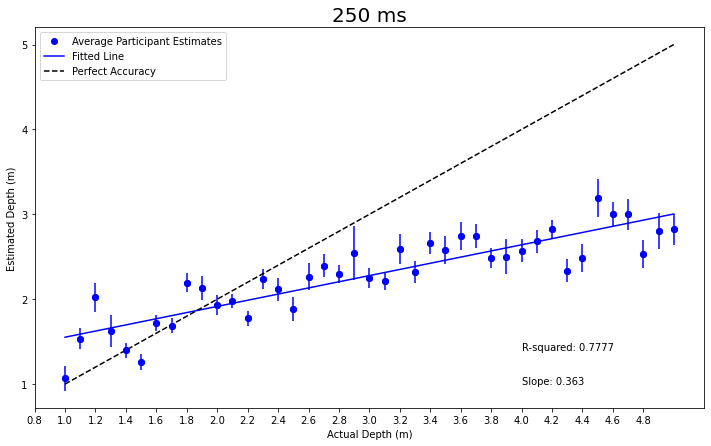

In [493]:
slope_250 = linreg_duration(final_x_250, final_y_250, ste_250, 250)[0]

slope: 0.311819    intercept: 1.513108
R-squared: 0.312090
Standard-error: 0.074130


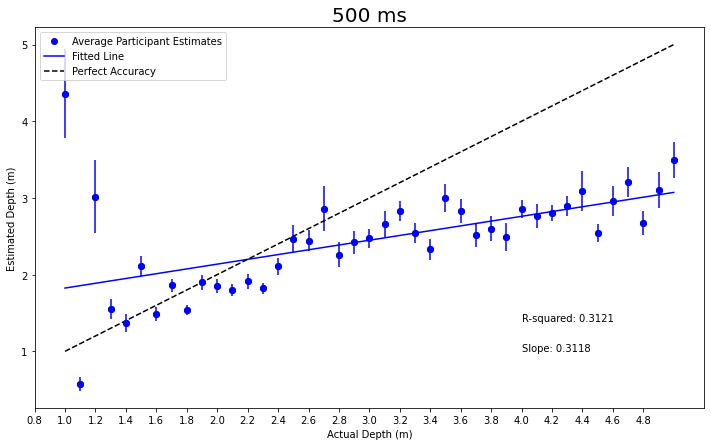

In [494]:
slope_500 = linreg_duration(final_x_500, final_y_500, ste_500, 500)[0]

slope: 0.507004    intercept: 0.834746
R-squared: 0.740405
Standard-error: 0.048700


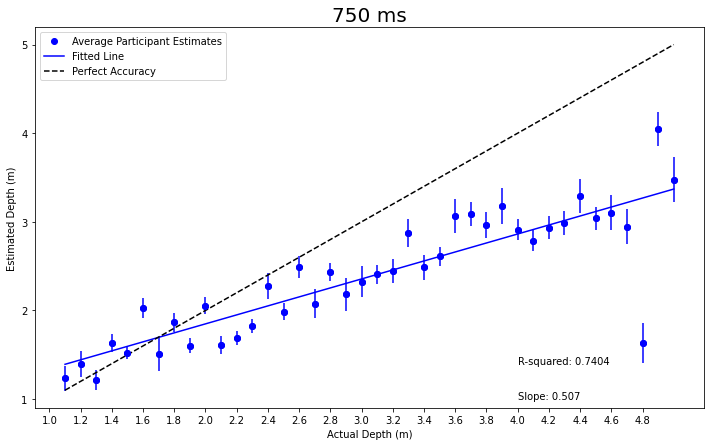

In [495]:
slope_750 = linreg_duration(final_x_750, final_y_750, ste_750, 750)[0]

slope: 0.392524    intercept: 1.287909
R-squared: 0.372596
Standard-error: 0.081562


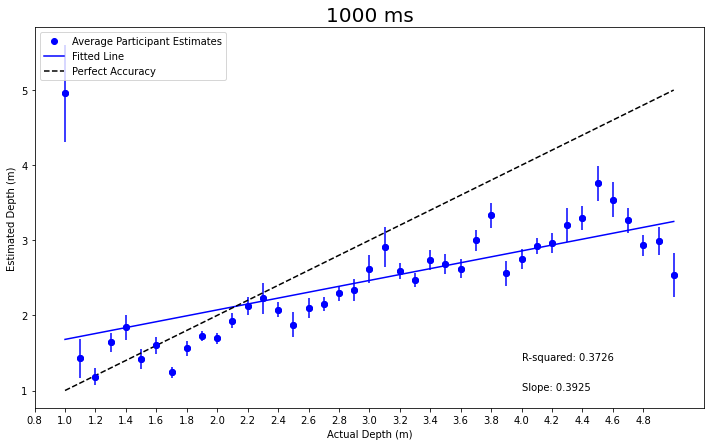

In [496]:
slope_1000 = linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000)[0]

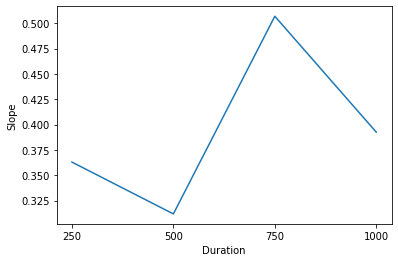

In [497]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.plot(xAxis,slopes)
plt.xlabel('Duration')
plt.ylabel('Slope')
plt.show()

### Plot Duration Data as Bar graph

In [397]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def duration_barGraph(x, y, ste, duration):

    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y, yerr=ste, width = 0.06, align='center', ecolor='black', capsize=3)
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")

    plt.show()

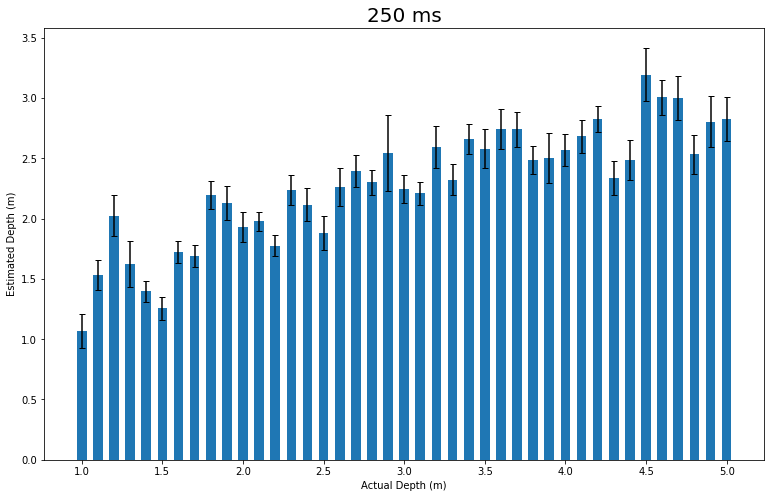

In [498]:
duration_barGraph(final_x_250, final_y_250, ste_250, 250)

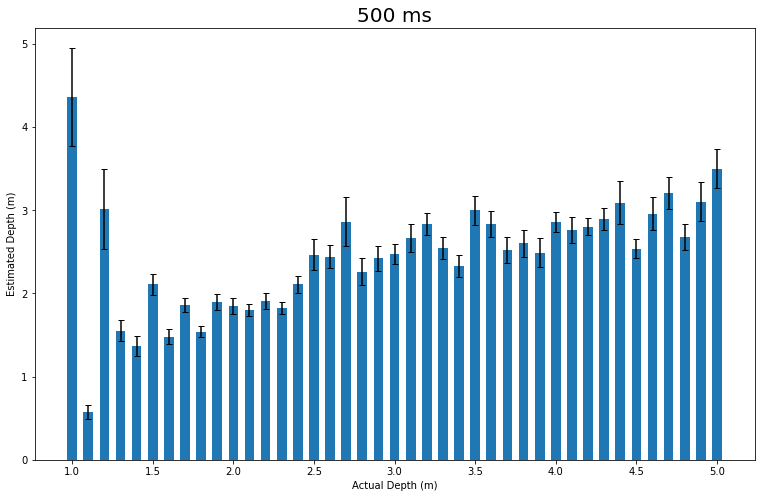

In [499]:
duration_barGraph(final_x_500, final_y_500, ste_500, 500)

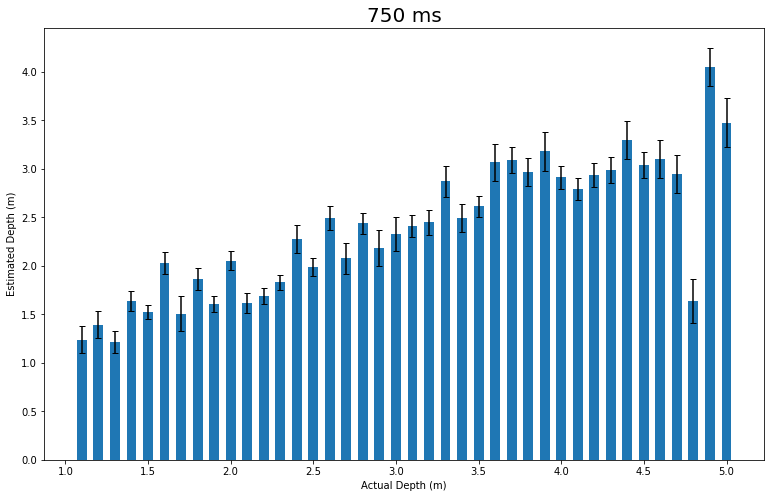

In [500]:
duration_barGraph(final_x_750, final_y_750, ste_750, 750)

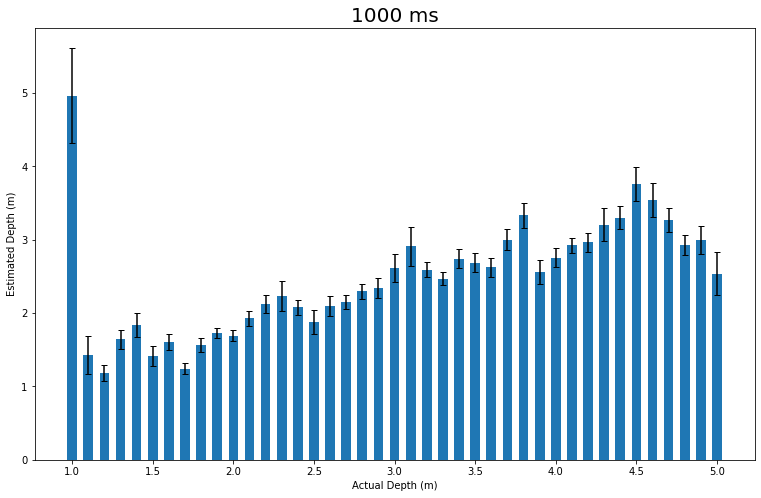

In [501]:
duration_barGraph(final_x_1000, final_y_1000, ste_1000, 1000)

### Plot Normalized Slopes

In [273]:
normalized = '/Users/prachi/Documents/depth_duration/analysis/normalized_data'

final_data = getxy(normalized)

## Execute this cell to prep for plotting
final_x_250 = final_data[0][0]
final_y_250 = final_data[1][0]
ste_250 = final_data[2][0]

final_x_500 = final_data[0][1]
final_y_500 = final_data[1][1]
ste_500 = final_data[2][1]

final_x_750 = final_data[0][2]
final_y_750 = final_data[1][2]
ste_750 = final_data[2][2]

final_x_1000 = final_data[0][3]
final_y_1000 = final_data[1][3]
ste_1000 = final_data[2][3]

In [332]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def normalized_linreg_duration(x, y, ste, duration, avg):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.5, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.7, text_r2) 
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "blue")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "blue")
    plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x/avg, label = "Perfect Accuracy Normalized", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [279]:
avg_average_particip_estim = 2.3936719328703706 # calculated in a cell below

slope: 0.117993    intercept: 0.568484
R-squared: 0.775099
Standard-error: 0.010178


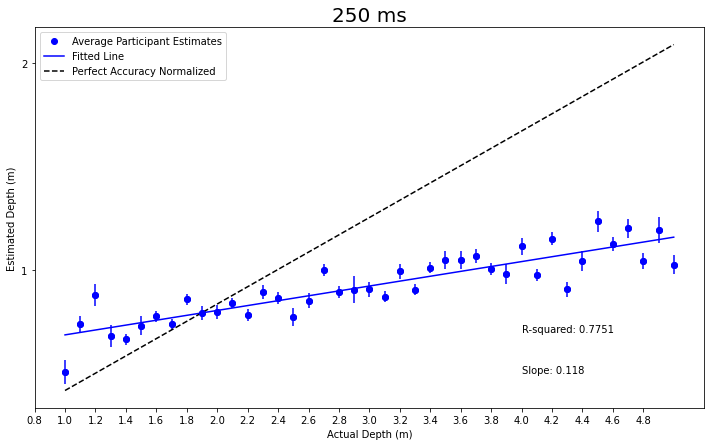

In [333]:
slope_250 = normalized_linreg_duration(final_x_250, final_y_250, ste_250, 250,
                                       avg_average_particip_estim)[0]

slope: 0.108710    intercept: 0.659832
R-squared: 0.334637
Standard-error: 0.024546


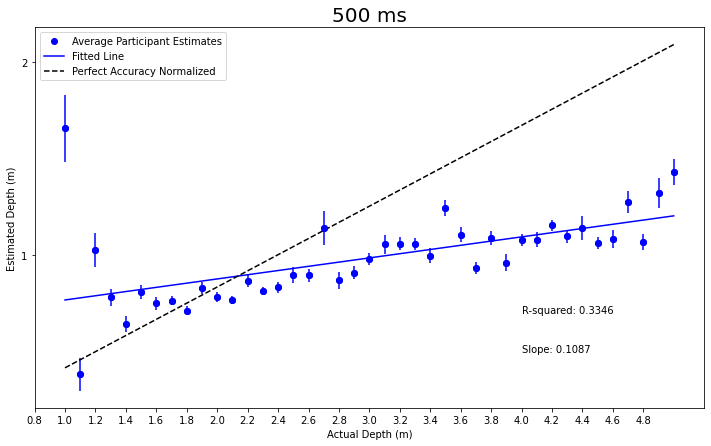

In [334]:
slope_500 = normalized_linreg_duration(final_x_500, final_y_500, ste_500, 500,
                                       avg_average_particip_estim)[0]

slope: 0.168254    intercept: 0.469056
R-squared: 0.799159
Standard-error: 0.013683


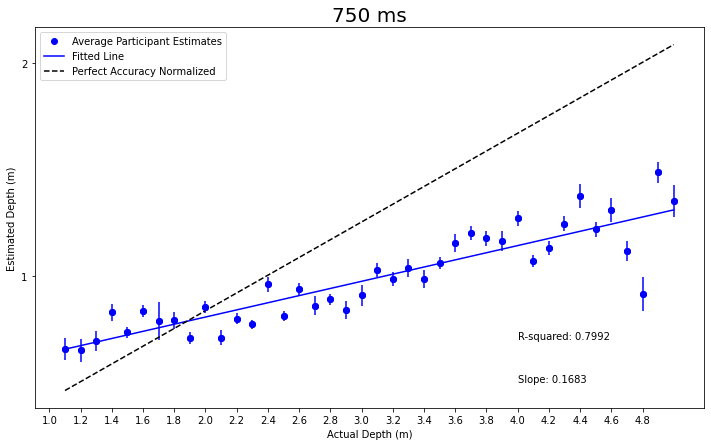

In [335]:
slope_750 = normalized_linreg_duration(final_x_750, final_y_750, ste_750, 750,
                                       avg_average_particip_estim)[0]

slope: 0.149889    intercept: 0.558598
R-squared: 0.441655
Standard-error: 0.026986


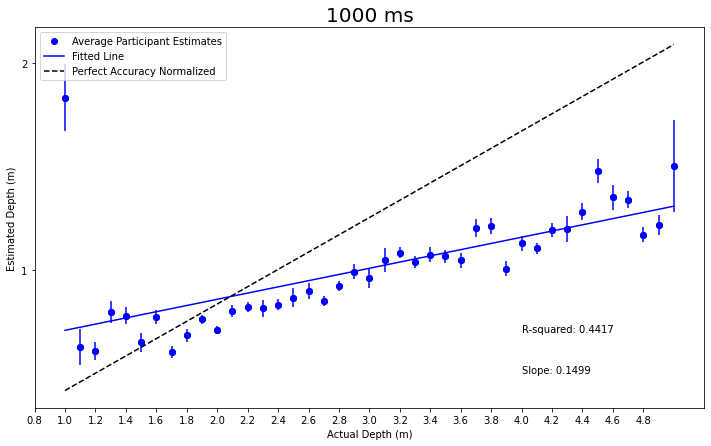

In [336]:
slope_1000 = normalized_linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000,
                                        avg_average_particip_estim)[0]

### Plot Normalized Duration Data as Bar graph

In [392]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def duration_barGraph(x, y, ste, duration):

    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y, yerr=ste, width = 0.06, align='center', ecolor='black', capsize=3)
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")

    plt.show()



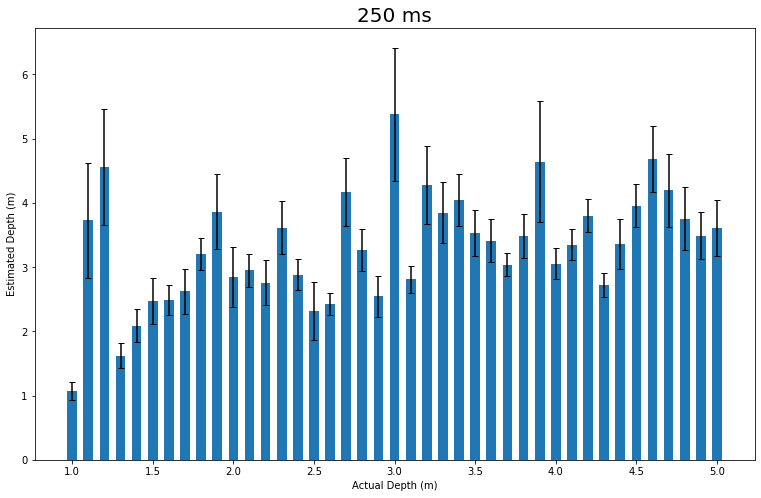

In [393]:
duration_barGraph(final_x_250, final_y_250, ste_250, 250)


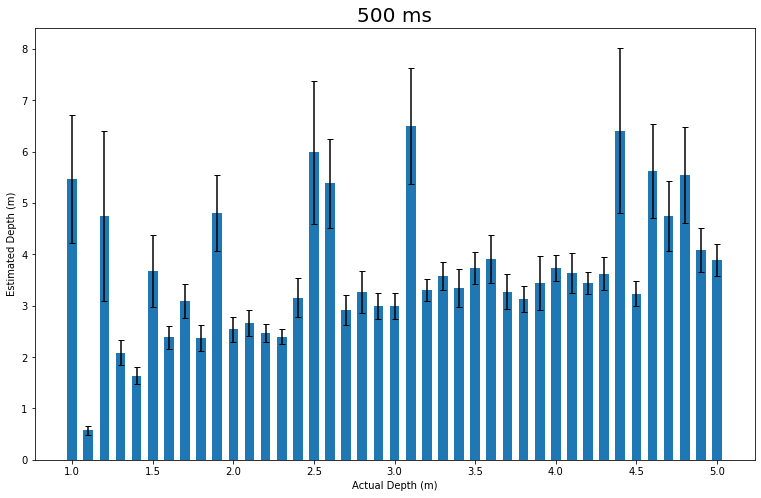

In [394]:
duration_barGraph(final_x_500, final_y_500, ste_500, 500)


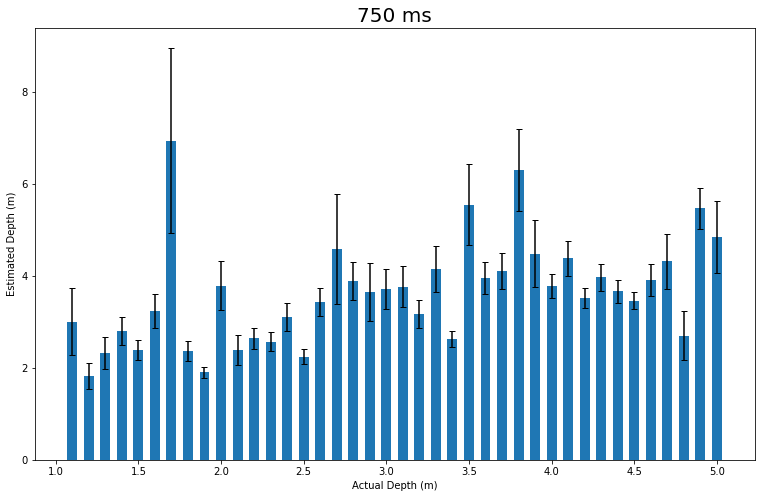

In [395]:
duration_barGraph(final_x_750, final_y_750, ste_750, 750)


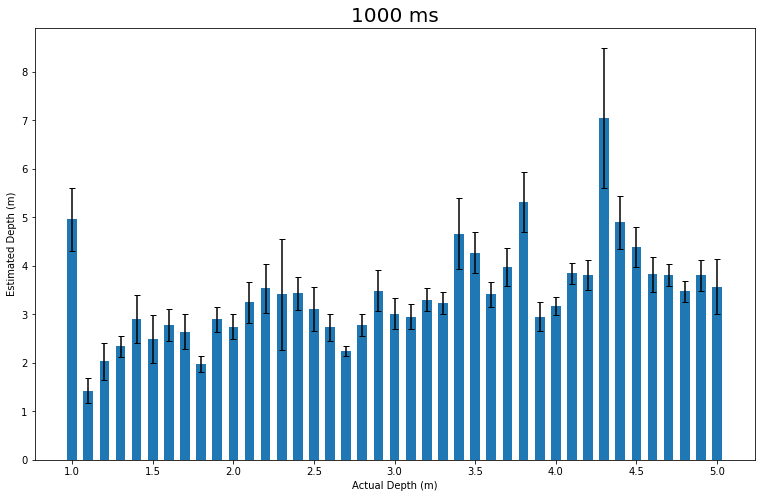

In [396]:
duration_barGraph(final_x_1000, final_y_1000, ste_1000, 1000)


In [31]:
#Calculate the T-test for the means of two independent samples of scores.

#This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 
#This test assumes that the populations have identical variances by default.

print("250ms vs. 500ms")
ttest_250_500 = stats.ttest_ind(final_y_250,final_y_500)
print(ttest_250_500)
print("250ms vs. 750ms")
ttest_250_750 = stats.ttest_ind(final_y_250,final_y_750)
print(ttest_250_750)
print("250ms vs. 1000ms")
ttest_250_1000 = stats.ttest_ind(final_y_250,final_y_1000)
print(ttest_250_1000)
print("500ms vs. 750ms")
ttest_500_750 = stats.ttest_ind(final_y_500,final_y_750)
print(ttest_500_750)
print("500ms vs. 1000ms")
ttest_500_1000 = stats.ttest_ind(final_y_500,final_y_1000)
print(ttest_500_1000)
print("750ms vs. 1000ms")
ttest_750_1000 = stats.ttest_ind(final_y_750,final_y_1000)
print(ttest_750_1000)

250ms vs. 500ms
Ttest_indResult(statistic=-1.4003453483863675, pvalue=0.16527649654548102)
250ms vs. 750ms
Ttest_indResult(statistic=-1.3517303173912831, pvalue=0.180319308669567)
250ms vs. 1000ms
Ttest_indResult(statistic=-0.4665884055689599, pvalue=0.6420625235699559)
500ms vs. 750ms
Ttest_indResult(statistic=0.1350266327434927, pvalue=0.8929342589693914)
500ms vs. 1000ms
Ttest_indResult(statistic=0.9475408347448053, pvalue=0.3462167217253924)
750ms vs. 1000ms
Ttest_indResult(statistic=0.861664538031487, pvalue=0.39148007803686224)


## Reaction Time and Total Time Stats 

In [33]:
import os 
import pandas as pd
import numpy as np

def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                # ONLY for test data NOT for actual 
        #         noNan_df = df[:10] 
        #         data.append(noNan_df)
                # uncomment line below for ACTUAL data 
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame

def averageTrialRT(datafolder):
    df = combineCSVs(datafolder)
    
    average_trial_RT = df["trial_RT"].mean()
    
    return average_trial_RT / 1000 # converts RT from ms to s 

def averageTotalTime(datafolder):
    df = combineCSVs(datafolder)
    
    average_TotalTime = df["totalTime"].mean()
    
    return average_TotalTime / 60000 # converts RT from ms to minutes
    

def averageExperimentTime(datafolder):
    df = combineCSVs(datafolder)
    
    average_ExperimentTime = df["experimentTime"].mean()
    
    return average_ExperimentTime / 60000 # converts RT from ms to minutes 


In [91]:
path = "/Users/prachi/Documents/depth_duration/analysis/data"

# N1_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N1"
# N2_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N2"
# N3_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N3"
# N4_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N4"

# N1N3N4_path = "/Users/prachi/Documents/depth_duration/analysis/N1N3N4"

avg_trialRT = averageTrialRT(path)
print('Average Trial RT (seconds): ', avg_trialRT)

avg_totalTime = averageTotalTime(path)
print('Average Total Time (minutes): ', avg_totalTime)

avg_experimentTime = averageExperimentTime(path)
print('Average Experiment Time (minutes): ', avg_experimentTime)


Average Trial RT (seconds):  4.2039556640625
Average Total Time (minutes):  23.42163
Average Experiment Time (minutes):  20.088085333333336


## One-Way Repeated Measures ANOVA

https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide.php

IV conditions: Duration - 250, 500, 750, 1000

IV: Actual Depth

DV: Depth Estimate 

H0: µ1 = µ2 = µ3 = … = µk where µ = population mean and k = number of related groups. 

HA: at least two means are significantly different


In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM


def subjectData(folderpath):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    data = []
    for filename in os.listdir(folderpath):
        if 'csv' in filename:
            path = folderpath + "/" + filename
            subj_data = getxy(path)
            data.append(subj_data)
    
    return data # list of data for all subjects 

def buildDF_subjectLinReg(folderpath):
    """
    Plot slopes for each participant
    """
    
    dict_data_slope = {'participant': [], 'duration': [], 'slope': []}
    
    dict_data_intercept = {'participant': [], 'duration': [], 'intercept': []}
    
    data = subjectData(folderpath)
    durations = [250, 500, 750, 1000]
    participant = 0
    for subject in data:
        for i in range(len(durations)): 
            final_x = subject[0][i]
            final_y = subject[1][i]
            ste = subject[2][i]

            x = np.array(final_x)
            y = np.array(final_y)
            ste = np.array(ste)

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            dict_data_slope['participant'].append(participant)
            dict_data_slope['duration'].append(durations[i])
            dict_data_slope['slope'].append(slope)
            
            dict_data_intercept['participant'].append(participant)
            dict_data_intercept['duration'].append(durations[i])
            dict_data_intercept['intercept'].append(intercept)
        
        participant += 1
            
    df_slope = pd.DataFrame(data=dict_data_slope)
    
    df_intercept = pd.DataFrame(data=dict_data_intercept)
    
    return df_slope, df_intercept

def getDurationAvgs(folderpath):
    df_slope, df_intercept = buildDF_subjectLinReg(folderpath)
    
    df_slope_250 = df_slope[df_slope["duration"] == 250]
    df_slope_500 = df_slope[df_slope["duration"] == 500]
    df_slope_750 = df_slope[df_slope["duration"] == 750]
    df_slope_1000 = df_slope[df_slope["duration"] == 1000]
    
    slope_avgs = {'250': df_slope_250['slope'].mean(),
                  '500': df_slope_500['slope'].mean(), 
                  '750': df_slope_750['slope'].mean(),
                  '1000': df_slope_1000['slope'].mean()}
    
    df_intercept_250 = df_intercept[df_intercept["duration"] == 250]
    df_intercept_500 = df_intercept[df_intercept["duration"] == 500]
    df_intercept_750 = df_intercept[df_intercept["duration"] == 750]
    df_intercept_1000 = df_intercept[df_intercept["duration"] == 1000]
    
    intercept_avgs = {'250': df_intercept_250['intercept'].mean(),
                  '500': df_intercept_500['intercept'].mean(), 
                  '750': df_intercept_750['intercept'].mean(),
                  '1000': df_intercept_1000['intercept'].mean()}
    
    print("Subject Slope Average for each Duration")
    print(slope_avgs)
    
    print("Subject Intercept Average for each Duration")
    print(intercept_avgs)
        

def repeatedMeasuresANOVA(folderpath):

    df_slope = buildDF_subjectLinReg(folderpath)[0]
    print("Dependent variable: Participant Slopes")
    #perform the repeated measures ANOVA
    print(AnovaRM(data=df_slope, depvar='slope', subject='participant', within=['duration']).fit())
    
    df_intercept = buildDF_subjectLinReg(folderpath)[1]
    print("Dependent variable: Participant Intercepts")
    #perform the repeated measures ANOVA
    print(AnovaRM(data=df_intercept, depvar='intercept', subject='participant', within=['duration']).fit())

path = "/Users/prachi/Documents/depth_duration/analysis/data"
normalized_path = '/Users/prachi/Documents/depth_duration/analysis/normalized_data'

participOutlier_normalized = '/Users/prachi/Documents/depth_duration/analysis/cleaned_normalized_data'



In [246]:
repeatedMeasuresANOVA(normalized_path)
# getDurationAvgs(participOutlier_normalized)


Dependent variable: Participant Slopes
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 14.9584 3.0000 297.0000 0.0000

Dependent variable: Participant Intercepts
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration  9.5539 3.0000 297.0000 0.0000



## Normalize Depth Estimates by Participant's Average Depth Estimation 

In [130]:
def getSubjectAvgDepthEstimation(subj_df):
    """
    Calculate the subject's average depth estimation 
    """
    subj_estimates_array = subj_df['depth_estimate'].to_numpy()
    avg = subj_estimates_array.mean()

    return avg

def normalizeData(subj_df, avg):
    """
    Divide each depth estimate by the subject's average depth estimation
    """
    
    subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x: x/avg)
    
    return subj_df

def getSubjectNormalizedData(filepath):
    data = removeMissedTrials(filepath)
    subj_avg = getSubjectAvgDepthEstimation(data)
    
    normalized_data = normalizeData(data, subj_avg)
    
    
    return normalized_data 
    
def create_csv(filepath, outputfolder):
    """
    Create CSV for each subject with normalized data 
    """
    normalized_data = getSubjectNormalizedData(filepath)
    
    split = filepath.split('/')
    file = split[-1]
    split_file = file.split('.')
    name = split_file[0]
    
    outputfilepath = outputfolder + '/' + name + '_normalized.csv'
    print(outputfilepath)
    try:
        normalized_data.to_csv(outputfilepath, index=False)
    except:
        print("Failed to create csv for: ", filepath)
        

def subjectNormalizedCSVs(folderpath, outputfolder):
    """
    Create CSVs for each subject with depth estimates normalized by average depth estimate 
    """
    subject_files = []
    for filename in os.listdir(folderpath):
        if 'csv' in filename:
            filepath = folderpath + "/" + filename
            subject_files.append(filepath)
            
    for file in subject_files:
        create_csv(file, outputfolder)

path = "/Users/prachi/Documents/depth_duration/analysis/data"

# N1_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N1"
# N2_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N2"
# N3_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N3"
# N4_path = "/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N4"

# N1N3N4_path = "/Users/prachi/Documents/depth_duration/analysis/N1N3N4"

destination = "/Users/prachi/Documents/depth_duration/analysis/normalized_data"

subjectNormalizedCSVs(path, destination)



### Plot subjects mean distance estimation

In [429]:
def averageEstimHistogram(folderpath):
    subjAverages = []
    subj_keep = []
    for filename in os.listdir(folderpath):
        if 'csv' in filename:
            filepath = folderpath + "/" + filename
            data = removeMissedTrials(filepath)
            subj_avg = getSubjectAvgDepthEstimation(data)
#             subjAverages.append(subj_avg)
            if subj_avg <= 8:
                subjAverages.append(subj_avg)
                subj_keep.append(filepath)
            
    num_bins = len(subjAverages)
    n, bins, patches = plt.hist(subjAverages, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Average Distance Estimate')
    plt.show()
    
    mids = 0.5*(bins[1:] + bins[:-1])
    probs = n / np.sum(n)

    mean = np.sum(probs * mids)  
    sd = np.sqrt(np.sum(probs * (mids - mean)**2))
    
    print(mean, sd)
    
    return subj_keep

data_path = '/Users/prachi/Documents/depth_duration/analysis/data'
averageEstimHistogram(data_path)

#### Take only the participants that have an Average Depth Estimation <= 8 and add to the folder below. 

8 was chosen since it is 3SD away from mean of distribution (mean does not include average depth estimations that are above 26) 

90/100 participants remain

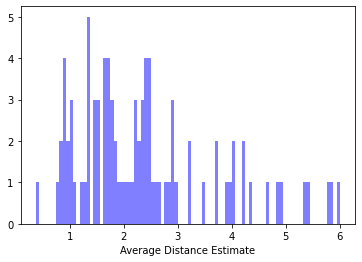

2.3936719328703706 1.2954907947065724


90

In [431]:
avg_estim_cleaned = '/Users/prachi/Documents/depth_duration/analysis/data_avgEstim_cleaned'
subjects = averageEstimHistogram(data_path)

# for file in subjects:
#     shutil.copy2(file, avg_estim_cleaned)

## Check that Sequences are balanced (N=25 for each)

In [44]:
data_path = '/Users/prachi/Documents/depth_duration/analysis/data'


In [71]:
import os
import pandas as pd
import shutil

sequence_count = {}
N1 = '/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N1'
N2 = '/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N2'
N3 = '/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N3'
N4 = '/Users/prachi/Documents/depth_duration/analysis/data_bysequence/N4'


lst_subjIDs = []
for file in os.listdir(data_path):
    if 'csv' in file:
        path = data_path + "/" + file
        df = pd.read_csv(path, index_col=None, header=0)
        sequenceName = df['sequenceName'][0]
        subjID = df['subjID'][0]
        lst_subjIDs.append(subjID)
        if sequenceName not in sequence_count:
            sequence_count[sequenceName] = 1
        else:
            sequence_count[sequenceName] += 1
        if sequenceName == 'sequence_N1':
            shutil.copy2(path, N1) 
        if sequenceName == 'sequence_N2':
            shutil.copy2(path, N2)
        if sequenceName == 'sequence_N3':
            shutil.copy2(path, N3) 
        if sequenceName == 'sequence_N4':
            shutil.copy2(path, N4)


set_subjIDs = set(lst_subjIDs)
print(len(set_subjIDs))

100


## Participant Level Exclusion --> Normalize Data --> Run analysis 

#### Count the number of outliers removed at the participant level 

In [143]:
#Outlier Cleaning - Participant level 

def get_participant_ids(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

def participant_OutlierRemoval(df, num_trials, num_blocks, num_participants):
    '''
    For each duration, each participant's average depth estimation is calculated.
    Calculate outlier range: (-3SD, +3SD) --> if an estimate is outside that participant's range, then remove as outlier
    
    Args:
        df = [df_250, df_500, df_750, df_1000]
        num_trials = the total number of trials a participant completes in an experiment (256)
        num_blocks = total number of blocks in an experiment (4)
        num_participants = total number of participants (18 - pilot testing)
        
    Returns:
        [Data before outliers were removed, Data with outliers removed according to guidelines stated above.] 
        Data is in this format: [df_250, df_500, df_750, df_1000]
    '''
    #Participants see an equal number of scenes at each duration across all blocks
    #So, calculation below accuractely finds the number of scenes seen at each duration 
    trials_per_duration = num_trials // num_blocks 
    
    participant_ids = get_participant_ids(df) #calls function to get a list of participant IDs 

    new_df = [] #updated dataframes are added to this list 
    for duration_df in df:
        duration_participant_dfs = []
        for p_id in participant_ids: #calculate average, standard deviation, and outlier parameters for each participant 
            select_participant = duration_df.where(duration_df["subjID"] == p_id) #selects rows by participant ID 
            p_avg = select_participant["depth_estimate"].mean()
            p_std = select_participant["depth_estimate"].std()
            
            new_participant = select_participant
            new_participant["Participant's Average"] = p_avg
            new_participant["Participant's StDev"] = p_std
            
            avg_minus_3SD = p_avg - (3 * p_std)
            avg_plus_3SD = p_avg + (3 * p_std)
            new_participant["Avg-3SD"] = avg_minus_3SD
            new_participant["Avg+3SD"] = avg_plus_3SD
            
            new_participant = new_participant.dropna() #remove all rows with NaN 
            duration_participant_dfs.append(new_participant)
            
        new_duration_df = pd.concat(duration_participant_dfs) #combine data for all participants of a specific duration 
        new_df.append(new_duration_df) #add duration dataframe to list of all data frames 
        
    for dur in new_df:
        p_outlier_col = [] #list of outlier values in the duration data frame 
        for idx, row in dur.iterrows():
            p_estim = row["depth_estimate"]
            p_avg_minus_3SD = row["Avg-3SD"]
            p_avg_plus_3SD = row["Avg+3SD"]
            if p_estim < p_avg_minus_3SD or p_estim > p_avg_plus_3SD: #label as outlier 
                p_outlier_col.append(1)
            else: #not an outlier 
                p_outlier_col.append(0)
        dur["Outlier"] = p_outlier_col #add values to the data frame 
        
    pre_outlier = new_df
    post_outlier = new_df
    
    count_outlier1 = [] #list of outlier removed for each duration 
    for dur in post_outlier: #if the value is an outlier, then remove it 
        indexNames = dur[dur["Outlier"] == 1].index
        dur.drop(indexNames, inplace=True)
        count_outlier1.append(len(indexNames)) #count of number of outliers removed for each duration 
        
    print(count_outlier1)
    return pre_outlier, post_outlier

In [201]:
def normalize_cleaned_subjDF(subjID, post_outlier_df):
    df = pd.concat(post_outlier_df)
    
    subj_df = df.loc[df['subjID'] == subjID]
        
    # calculate subject's average depth estimation 
    subj_estimates_array = subj_df['depth_estimate'].to_numpy()
    avg = subj_estimates_array.mean()
    
    # divide each depth estimate by the subject's average depth estimation 
    subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x: x/avg)    
    return subj_df
    
def create_csv(filepath, subjID, post_outlier_df, destination):
    """
    Create CSV for each subject with normalized data 
    """
    normalized_data = normalize_cleaned_subjDF(subjID, post_outlier_df)
    
    outputfilepath = destination + '/' + str(subjID) + '_cleaned_normalized.csv'
    print(outputfilepath)
    try:
        normalized_data.to_csv(outputfilepath, index=False)
    except:
        print("Failed to create csv for: ", filepath)  
        
def create_all_subjCSVs(filepath, participants, post_outlier_df, destination):
    for subj in participants:
        create_csv(filepath, subj, post_outlier_df, destination)

In [187]:
data_path = '/Users/prachi/Documents/depth_duration/analysis/data'

data = roundActualDepth(data_path)

post_outlier = participant_OutlierRemoval(data, 256, 4, 100)[1]

participant_list = get_participant_ids(post_outlier)

destination_path = '/Users/prachi/Documents/depth_duration/analysis/cleaned_normalized_data'


[54, 50, 49, 36]


In [205]:
# create_all_subjCSVs(data_path, participant_list, post_outlier, destination_path)

### Analysis without Depth Level Outlier Cleaning

In [208]:
import os 
import pandas as pd
import numpy as np
import math

def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                # ONLY for test data NOT for actual 
        #         noNan_df = df[:10] 
        #         data.append(noNan_df)
                # uncomment line below for ACTUAL data 
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
            input_data.at[idx, 'unitSelection'] = 'meters'

        
    
    return input_data

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = getUnitConveredData(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)
    
    return input_data



def durationDfs(datafolder):
    """
    Seperate the the data into seperate dataframes for each duration condition
    """
    
    cleaned_data = removeMissedTrials(datafolder)
    
    data_250ms = cleaned_data[cleaned_data['duration'] == 250.0]
    data_500ms = cleaned_data[cleaned_data['duration'] == 500.0]
    data_750ms = cleaned_data[cleaned_data['duration'] == 750.0]
    data_1000ms = cleaned_data[cleaned_data['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]

def roundActualDepth(datafolder):
    """
    Round Actual Depth value to nearest tenth
    - Actual depth values from the Kinect are very specific (ex. 3.128)
    - Need to round to calculate meaningful outlier params 
    """
    data = durationDfs(datafolder)
    
    for duration in data:
        for idx, row in duration.iterrows():
            actual_depth = row['actual_depth']
            rounded_depth = round(actual_depth,1) # round depth to the nearest tenth
            duration.at[idx,'actual_depth'] = rounded_depth      
        
    return data
    

def pivotTable(datafolder):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    data = roundActualDepth(datafolder)
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        
        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
    
    return result_tables

import scipy.stats as stats

def getxy(datafolder):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        xs = [x_250, x_500, x_750, x_1000]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    data = pivotTable(datafolder)
    xs = []
    ys = []
    stes = []
    for table in data:
        x = []
        y = []
        ste = []
        for idx, row in table.iterrows():
            x.append(idx) #idx is the actual depth value 
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        
    return xs, ys, stes 

def createVars(folderpath):
    """
    Create variables for final data by duration, for a specific sequence 
    """
    final_data = getxy(folderpath)
    final_x_250 = final_data[0][0]
    final_y_250 = final_data[1][0]
    ste_250 = final_data[2][0]

    final_x_500 = final_data[0][1]
    final_y_500 = final_data[1][1]
    ste_500 = final_data[2][1]

    final_x_750 = final_data[0][2]
    final_y_750 = final_data[1][2]
    ste_750 = final_data[2][2]

    final_x_1000 = final_data[0][3]
    final_y_1000 = final_data[1][3]
    ste_1000 = final_data[2][3]
    
    return [[final_x_250, final_y_250, ste_250], 
            [final_x_500, final_y_500, ste_500], 
            [final_x_750, final_y_750, ste_750], 
            [final_x_1000, final_y_1000, ste_1000]]

#Calculate the T-test for the means of two independent samples of scores.

#This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 
#This test assumes that the populations have identical variances by default.
def durationStatsTests(folderpath):
    finaldata = createVars(folderpath)
    
    final_y_250 = finaldata[0][1]
    final_y_500 = finaldata[1][1]
    final_y_750 = finaldata[2][1]
    final_y_1000 = finaldata[3][1]
    
    print("250ms vs. 500ms")
    ttest_250_500 = stats.ttest_ind(final_y_250,final_y_500)
    print(ttest_250_500)
    print("250ms vs. 750ms")
    ttest_250_750 = stats.ttest_ind(final_y_250,final_y_750)
    print(ttest_250_750)
    print("250ms vs. 1000ms")
    ttest_250_1000 = stats.ttest_ind(final_y_250,final_y_1000)
    print(ttest_250_1000)
    print("500ms vs. 750ms")
    ttest_500_750 = stats.ttest_ind(final_y_500,final_y_750)
    print(ttest_500_750)
    print("500ms vs. 1000ms")
    ttest_500_1000 = stats.ttest_ind(final_y_500,final_y_1000)
    print(ttest_500_1000)
    print("750ms vs. 1000ms")
    ttest_750_1000 = stats.ttest_ind(final_y_750,final_y_1000)
    print(ttest_750_1000)
    
    # stats f_oneway functions takes the groups as input and returns F and P-value
    fvalue, pvalue = stats.f_oneway(final_y_250, final_y_500, final_y_750, final_y_1000)
    print("All durations: fvalue=", fvalue, "pvalue=",pvalue)
    
    return None 

participOutlierCleaning_normalized = '/Users/prachi/Documents/depth_duration/analysis/cleaned_normalized_data'

durationStatsTests(participOutlierCleaning_normalized)

250ms vs. 500ms
Ttest_indResult(statistic=-1.3619950250754462, pvalue=0.17702233921981564)
250ms vs. 750ms
Ttest_indResult(statistic=-1.311609328597004, pvalue=0.19345102469918957)
250ms vs. 1000ms
Ttest_indResult(statistic=-1.5505924668766276, pvalue=0.12494660057112555)
500ms vs. 750ms
Ttest_indResult(statistic=-0.021830344963854383, pvalue=0.9826383332146396)
500ms vs. 1000ms
Ttest_indResult(statistic=-0.32384936575544826, pvalue=0.7468972160424063)
750ms vs. 1000ms
Ttest_indResult(statistic=-0.29075465838909986, pvalue=0.7720009098867606)
All durations: fvalue= 0.9165873431034741 pvalue= 0.43434679632649464
